In [250]:
import math


import numpy as np
import matplotlib.pyplot as plt

In [234]:
def find_six_neighbors(s: np.ndarray):
    """
    Parameters
    ----------
        s: (N+2)x(N+2) array
    Returns
    -------
        s1, s2, s3, s4, s5, s6: NxN array
    """
    # 1. find the eight neighbors (including diagonal ones) in a square grid
    s_u = s[:-2, 1:-1]
    s_d = s[2:, 1:-1]
    s_l = s[1:-1, :-2]
    s_r = s[1:-1, 2:]
    
    # 2. 4 diagonal ones
    s_lu = s[:-2, :-2]
    s_ru = s[:-2, 2:]
    s_ld = s[2:, :-2]
    s_rd = s[2:, 2:]
    
    # 3. the 6 neighbors
    s1 = s_u
    s2 = s_d
    s3 = s_l
    s4 = s_r
    
    s5 = np.empty([s.shape[0]-2, s.shape[1]-2])
    s6 = np.empty([s.shape[0]-2, s.shape[1]-2])
    
    s5[:,0::2] = s_ld[:, 0::2]
    s6[:,0::2] = s_rd[:, 0::2]
    
    s5[:,1::2] = s_lu[:, 1::2]
    s6[:,1::2] = s_ru[:, 1::2]
    
    return (s1, s2, s3, s4, s5, s6)


def contrast(s, k:float=0.8, a: float=1):
    # y = (np.exp(2*s) - 1) / (np.exp(2*s) + 1)
    # cm = plt.cm.gray(y)
    
    # s: 0-1
    vapor_contrast = k*s # s<1
    vapor_color = plt.cm.gray(vapor_contrast)
    
    # s > 1
    ice_contrast = (np.exp(2*(s-0.9)*a) - 1) / (np.exp(2*(s-0.9)*a) + 1)
    ice_color = plt.cm.ocean_r(ice_contrast)
    
    y = np.zeros_like(s)
    y[s<1] = vapor_contrast[s<1]
    y[s>=1] = ice_contrast[s>=1]
    
    cm = np.zeros([s.shape[0], 4]) # 4: rgba
    cm[s<1] = vapor_color[s<1]
    cm[s>=1] = ice_color[s>=1]
    
    return y, cm

In [212]:
class ReiterCellularAutomata:
    
    def __init__(self, grid_size: int, alpha: float, beta: float, gamma: float):
        self.grid_size = grid_size
        self.s = np.ones([grid_size+2, grid_size+2]) * beta #<1
        self.s[grid_size//2+1, grid_size//2+1] = 1.0
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def frozen(self):
        return self.s[1:-1, 1:-1] >= 1
    
    def have_frozen_neighbors(self):
        s1, s2, s3, s4, s5, s6 = find_six_neighbors(self.s)
        return np.logical_or.reduce([
            s1>=1,
            s2>=1,
            s3>=1,
            s4>=1,
            s5>=1,
            s6>=1,
        ])
    
    def receptive(self):
        return np.logical_or(self.frozen(), self.have_frozen_neighbors())
    
    def update(self):
        receptive = self.receptive() # boolean array
        
        v = np.zeros([self.grid_size+2, self.grid_size+2])
        v[1:-1, 1:-1][receptive] = self.s[1:-1, 1:-1][receptive] + self.gamma
        
        u = np.zeros([self.grid_size+2, self.grid_size+2])
        u[0, :] = self.beta
        u[-1, :] = self.beta
        u[:, 0] = self.beta
        u[:, -1] = self.beta
        u[1:-1, 1:-1][~receptive] = self.s[1:-1, 1:-1][~receptive]
        
        u1,u2,u3,u4,u5,u6 = find_six_neighbors(u)
        u_mean = (u1 + u2 + u3 + u4 + u5 + u6) / 6.0
        
        u[1:-1, 1:-1] = u[1:-1, 1:-1] + self.alpha*(u_mean - u[1:-1, 1:-1])
        self.s[1:-1, 1:-1] = u[1:-1, 1:-1] + v[1:-1, 1:-1]
        
    def draw(self, ax: plt.Axes):
        R, C = np.meshgrid(np.arange(self.grid_size+2), np.arange(self.grid_size+2), indexing="ij")
        X = 1.5*C
        Y = math.sqrt(3) * R + (C%2) * math.sqrt(3) / 2
        _, cm = contrast(self.s.flatten(), a=0.3)
        ax.scatter(X.flatten(), Y.flatten(), c=cm, s=3.0)

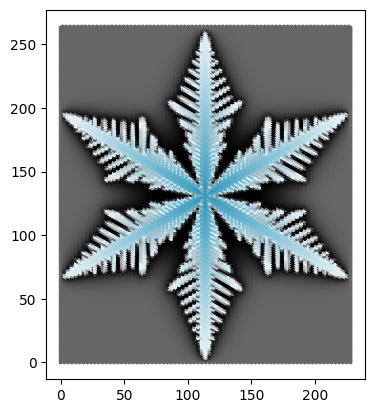

In [216]:
ca = ReiterCellularAutomata(grid_size=151, alpha=0.5, beta=0.5, gamma=0.001)

N = 800
for i in range(N):
    ca.update()
    
fig, ax = plt.subplots()
ax.set_aspect('equal')
ca.draw(ax)


In [207]:
ca.s.max()

2.5396445111311503

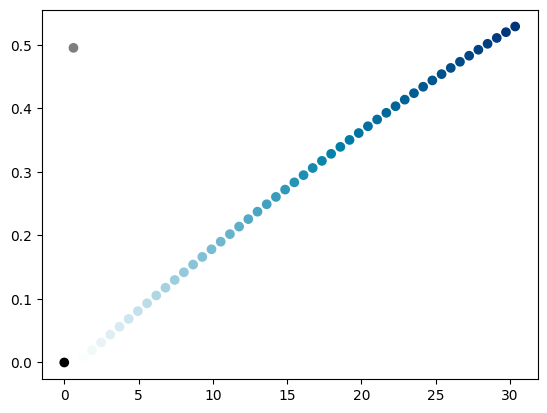

In [249]:
x = np.linspace(0, 30.35)
y, cm = contrast(x, k=0.8, a=0.02)
plt.scatter(x, y, c=cm)

$$\begin{align} 
  x &= \frac{3}{2} L c \\ 
  y &= \sqrt{3}Lr + (c\%2)\frac{\sqrt{3}}{2}L \end{align}$$
